In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from model_config import ModelConfig
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
transition_window =10

warmup_start = '20210421'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

# Learning rate
learning_rate = 0.001

In [44]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)
vax_statuses = [Vax.yes, Vax.no]
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
x_test = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)


y_train = {}
y_train['G_in'] = tf.cast(df.loc[train_start:train_end,'general_ward_in'], dtype=tf.float32)
y_train['G_count'] = tf.cast(df.loc[train_start:train_end,'general_ward_count'], dtype=tf.float32)
y_train['I_count'] = tf.cast(df.loc[train_start:train_end,'icu_count'], dtype=tf.float32)
y_train['D_in'] = tf.cast(df.loc[train_start:train_end,'deaths_covid'], dtype=tf.float32) + 1

y_test = {}
y_test['G_in'] = tf.cast(df.loc[train_start:test_end,'general_ward_in'], dtype=tf.float32)
y_test['G_count'] = tf.cast(df.loc[train_start:test_end,'general_ward_count'], dtype=tf.float32)
y_test['I_count'] = tf.cast(df.loc[train_start:test_end,'icu_count'], dtype=tf.float32)
y_test['D_in'] = tf.cast(df.loc[train_start:test_end,'deaths_covid'], dtype=tf.float32)

In [45]:
config = ModelConfig.from_json('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model_config_new_format.json')

In [46]:
config

In [47]:
model = CovidModel([Vax.no, Vax.yes], [Comp.A, Comp.M, Comp.G, Comp.GR, Comp.I, Comp.IR, Comp.D],
                 transition_window,
                config, posterior_samples=1000, debug_disable_theta=False,
                  fix_variance=True)

pre_training_preds=model.call(x_train)

In [48]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,#beta_1=0.1, beta_2=0.1
)
#loss((y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in']), pre_training_preds)

In [49]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/new_vax_model_new_config/', df, x_test, y_test, state_abbrev, train_start, train_end, test_start, test_end)

ERROR:tensorflow:Failed to start profiler: Another profiler is running.


Epoch 1/2000
G count: -108.16419219970703
G in: -5.86333703994751
I count: -22.46894073486328
D in: -6.109679698944092
1/1 [==============================] - 45s 45s/step - loss: 187.5019
Epoch 2/2000
ERROR:tensorflow:Failed to start profiler: Another profiler is running.
G count: -108.06254577636719
G in: -5.858447074890137
I count: -22.471803665161133
D in: -6.12855339050293
1/1 [==============================] - 46s 46s/step - loss: 187.3985
Epoch 3/2000
G count: -106.2367935180664
G in: -5.776280879974365
I count: -22.249134063720703
D in: -6.136956214904785
1/1 [==============================] - 49s 49s/step - loss: 185.2516
Epoch 4/2000
G count: -106.47051239013672
G in: -5.853972911834717
I count: -22.120271682739258
D in: -6.120956897735596
1/1 [==============================] - 47s 47s/step - loss: 185.3916
Epoch 5/2000
G count: -104.81529235839844
G in: -5.778074741363525
I count: -21.971263885498047
D in: -6.142227649688721
1/1 [==============================] - 48s 48s/step

KeyboardInterrupt: 

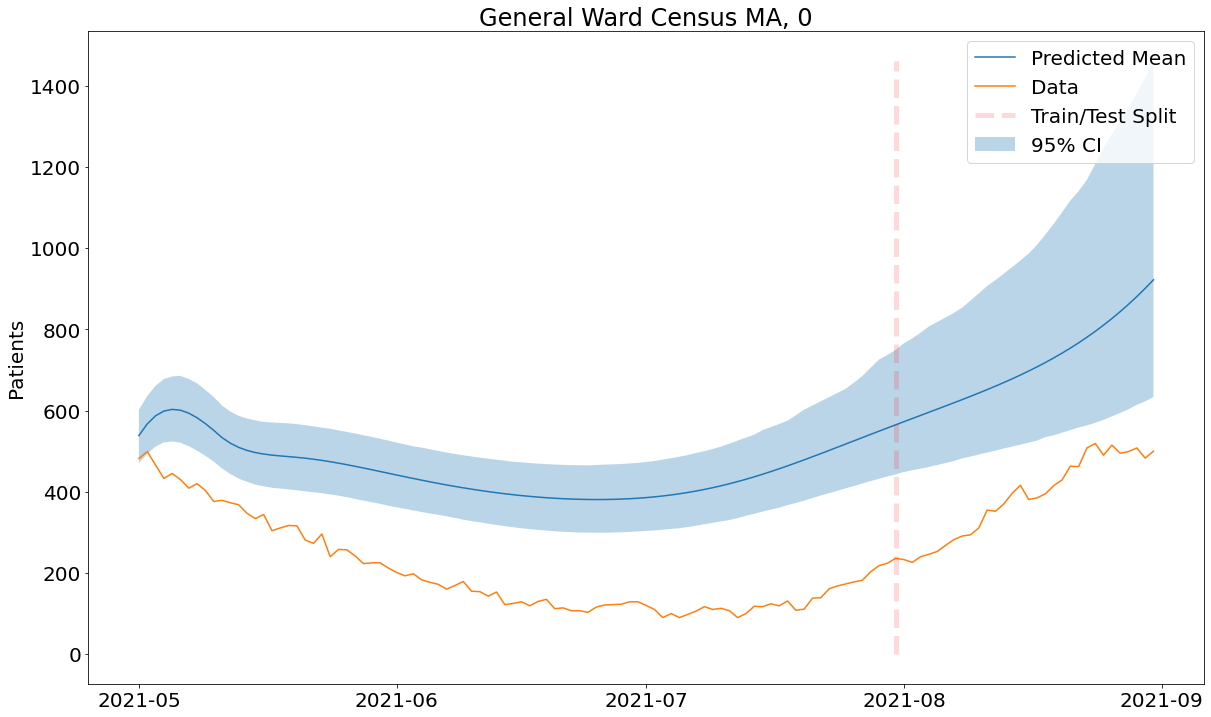

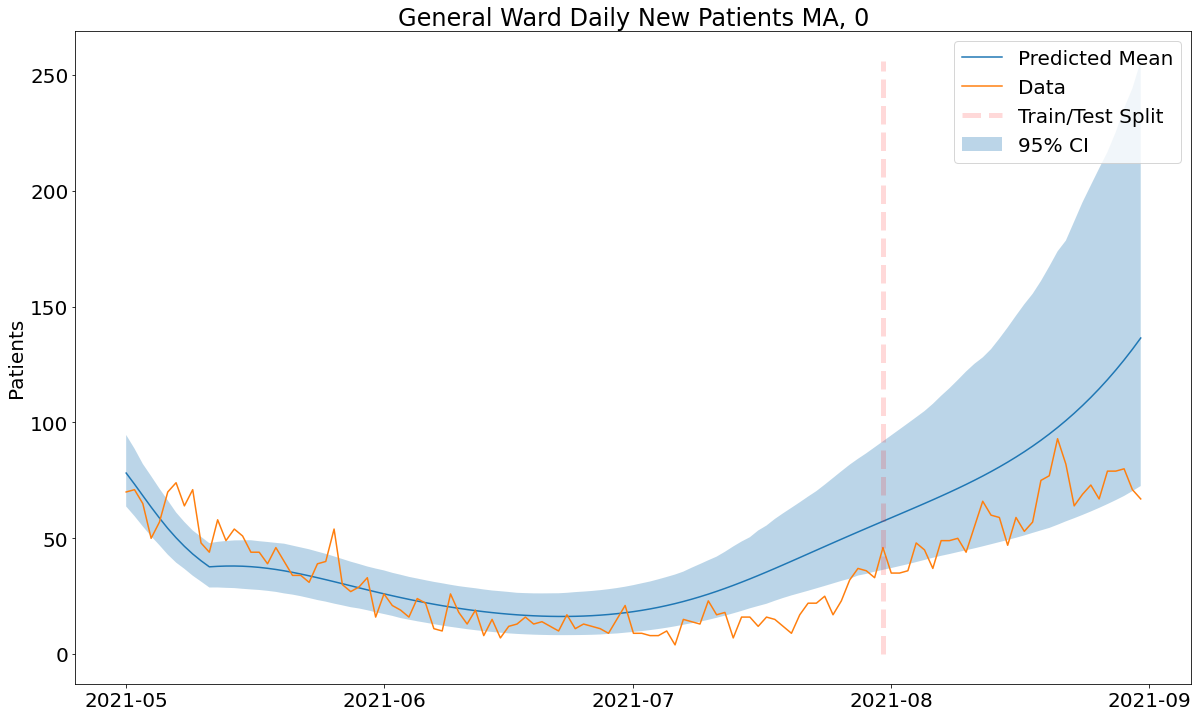

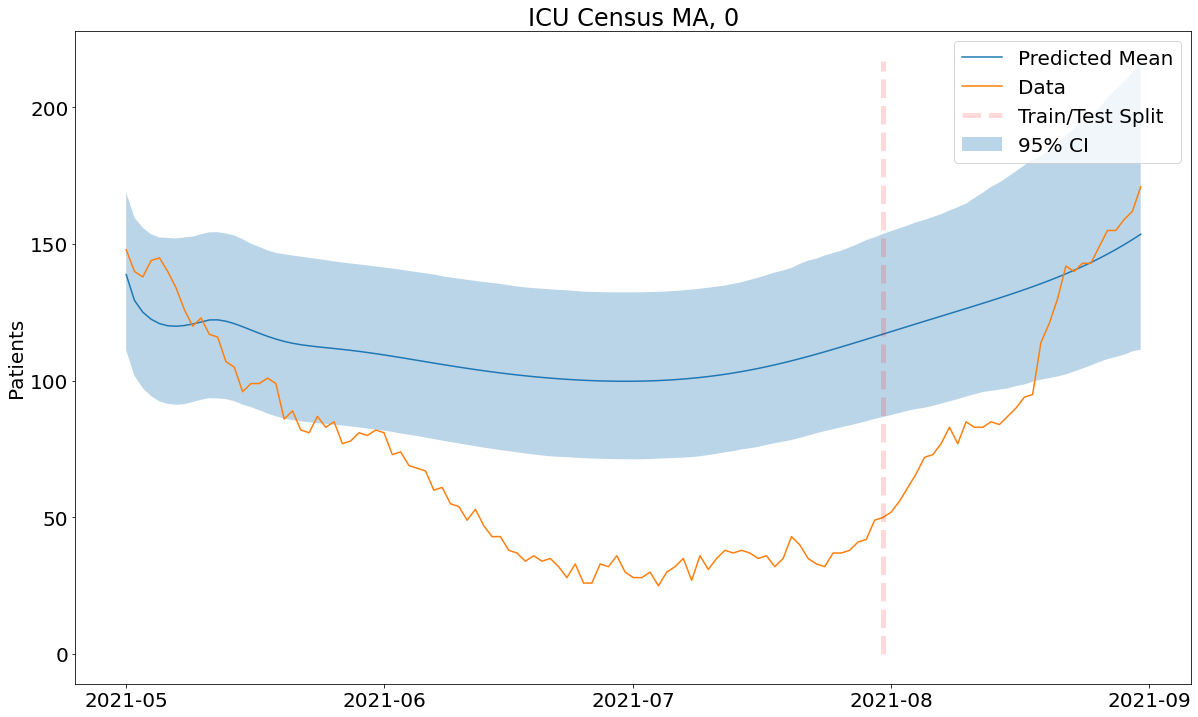

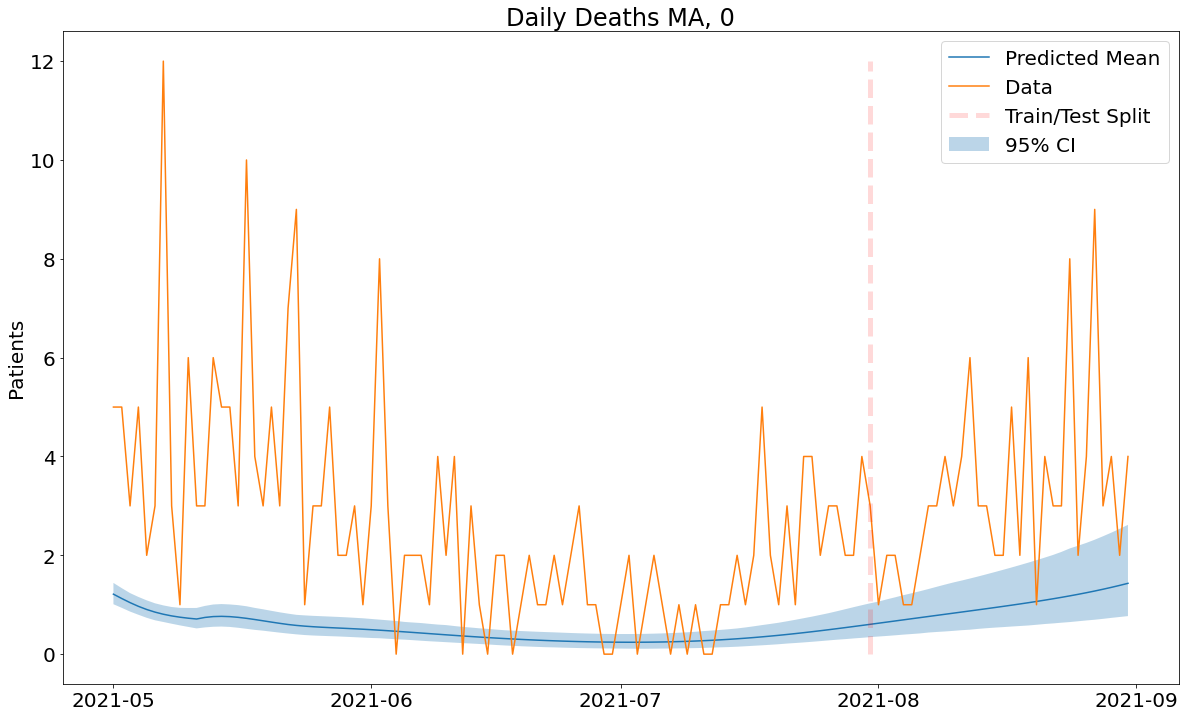

In [50]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([(y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in'])]),
         epochs=2000, batch_size=0,
        callbacks=logging_callbacks)

In [ ]:
model.variables

Text(0.5, 1.0, 'ICU Count')

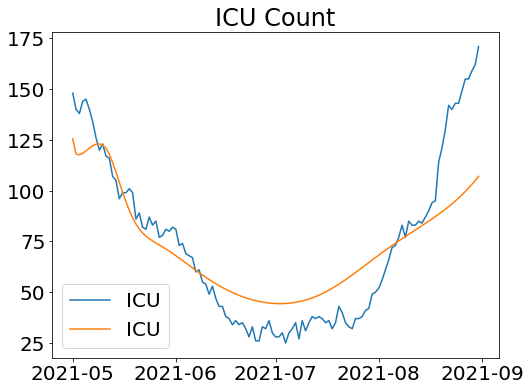

In [41]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_test), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test['I_count'], label='ICU')
plt.plot(df.loc[train_start:test_end].index.values, preds[0][2], label='ICU')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('ICU Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Count')

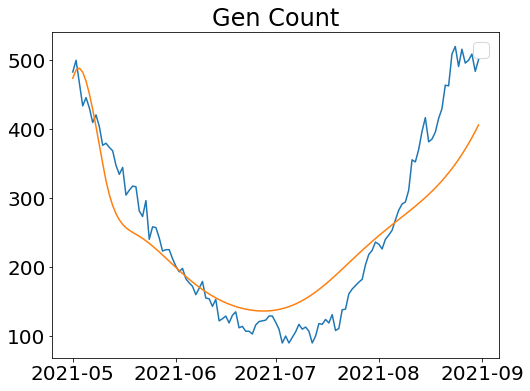

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][0])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Influx')

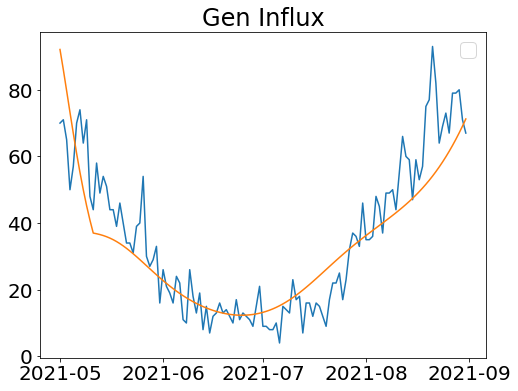

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][1])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Influx')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Death Influx')

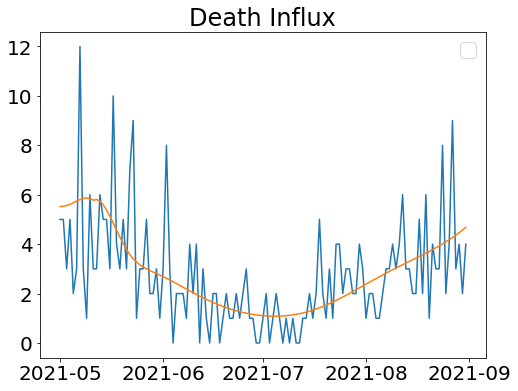

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['D_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][3])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Death Influx')

In [10]:
pred_draws = model.call(x_test)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/keras/engine/training.py", line 789, in train_step
    y, y_pred, sample_weight, regularization_losses=self.losses)  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1046, in __call__
    return outputs  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 79, in call
    self._sample_and_reparameterize()  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 1347, in _sample_and_reparameterize
    [dist.log_prob(j + 1) for dist in poisson_I_bar_dist_samples]) /  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/tensorflow/python/ut

In [11]:
numpy_draws  = pred_draws.numpy().squeeze()
pred_G_count = numpy_draws[0,:,:]
pred_G_in =  numpy_draws[1,:,:]
pred_I_count = numpy_draws[2,:,:]
pred_D_in = numpy_draws[3,:,:]

In [12]:
pred_G_count_lower, pred_G_count_mean, pred_G_count_upper = (np.percentile(pred_G_count,2.5, axis=1),
                                                             np.mean(pred_G_count, axis=1),
                                                             np.percentile(pred_G_count,97.5, axis=1))

pred_G_in_lower, pred_G_in_mean, pred_G_in_upper = (np.percentile(pred_G_in,2.5, axis=1),
                                                             np.mean(pred_G_in, axis=1),
                                                             np.percentile(pred_G_in,97.5, axis=1))

pred_I_count_lower, pred_I_count_mean, pred_I_count_upper = (np.percentile(pred_I_count,2.5, axis=1),
                                                             np.mean(pred_I_count, axis=1),
                                                             np.percentile(pred_I_count,97.5, axis=1))

pred_D_in_lower, pred_D_in_mean, pred_D_in_upper = (np.percentile(pred_D_in,2.5, axis=1),
                                                             np.mean(pred_D_in, axis=1),
                                                             np.percentile(pred_D_in,97.5, axis=1))

Text(0.5, 1.0, 'General Ward Census')

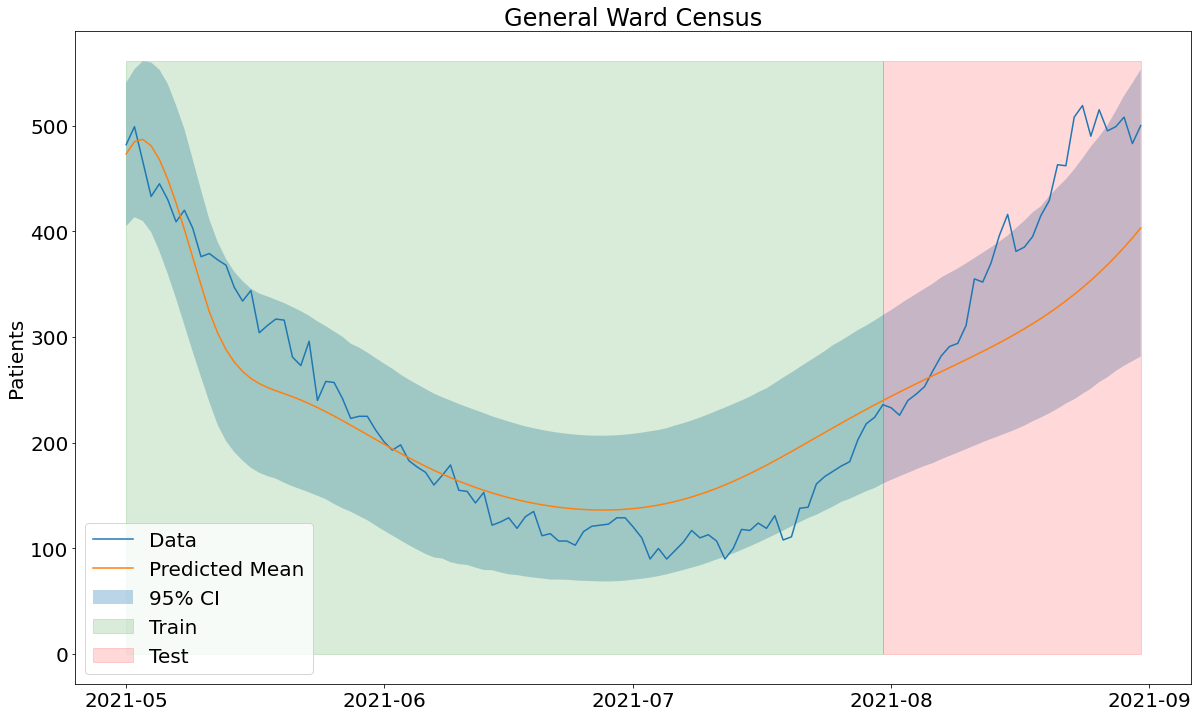

In [83]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], label='Data')
plt.plot(df.loc[train_start:test_end].index.values, pred_G_count_mean, label='Predicted Mean')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_count_lower, pred_G_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_count_upper), max(y_test['G_count']))
plt.fill_between(df.loc[train_start:train_end].index.values,0,max_y, alpha=0.15, color='green', label='Train')
plt.fill_between(df.loc[train_end:test_end].index.values,0,max_y, alpha=0.15, color='red', label='Test')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Census')

Text(0.5, 1.0, 'General Ward Census')

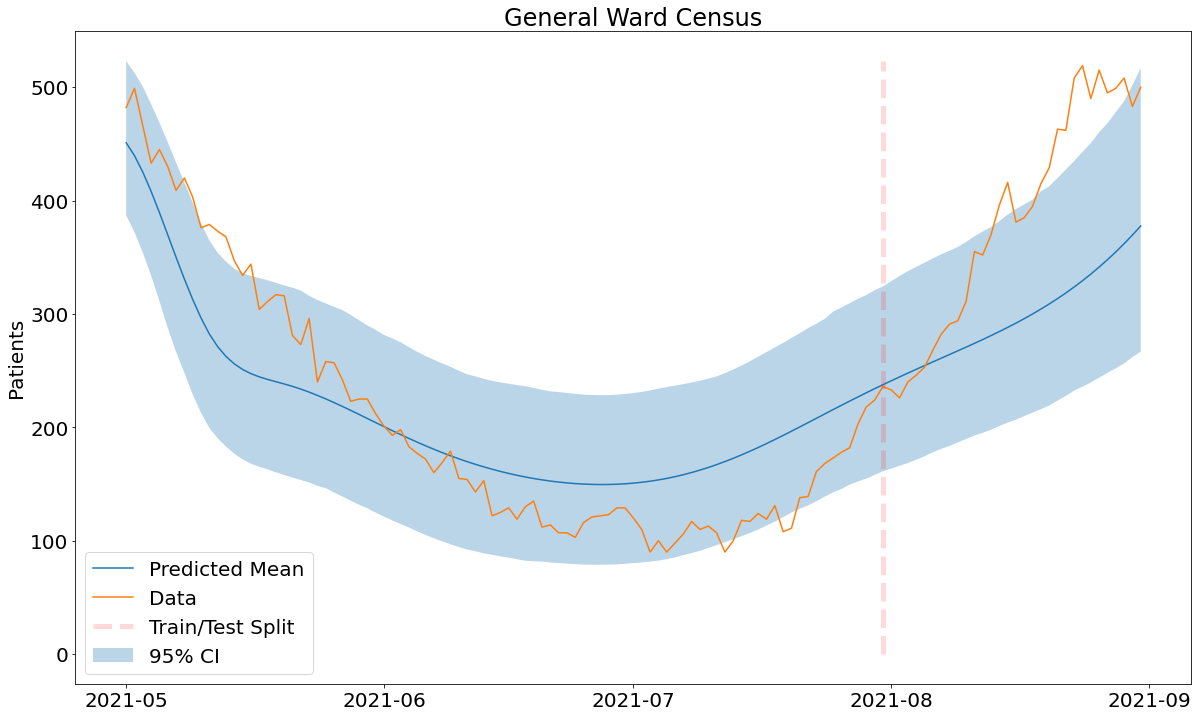

In [13]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_G_count_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_count_lower, pred_G_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_count_upper), max(y_test['G_count']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Census')
#plt.savefig('G_count.png')

Text(0.5, 1.0, 'General Ward Daily New Patients')

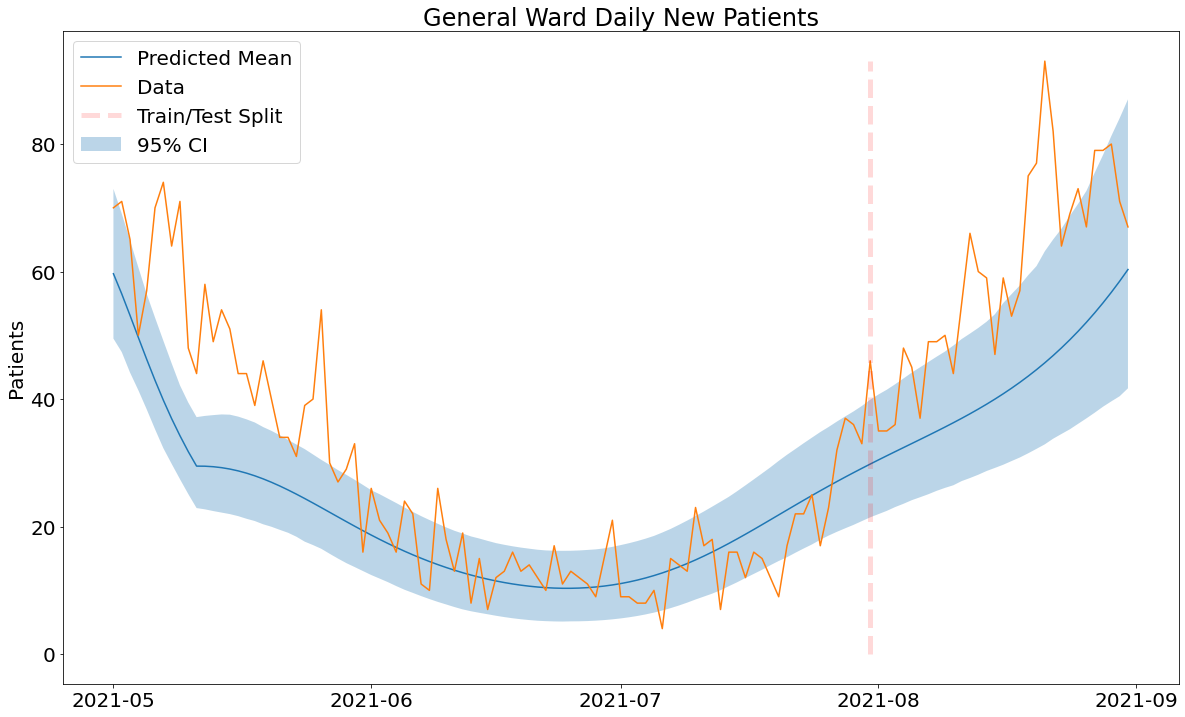

In [14]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_G_in_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_in'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_in_lower, pred_G_in_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_in_upper), max(y_test['G_in']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Daily New Patients')
#plt.savefig('G_in.png')

Text(0.5, 1.0, 'ICU Census')

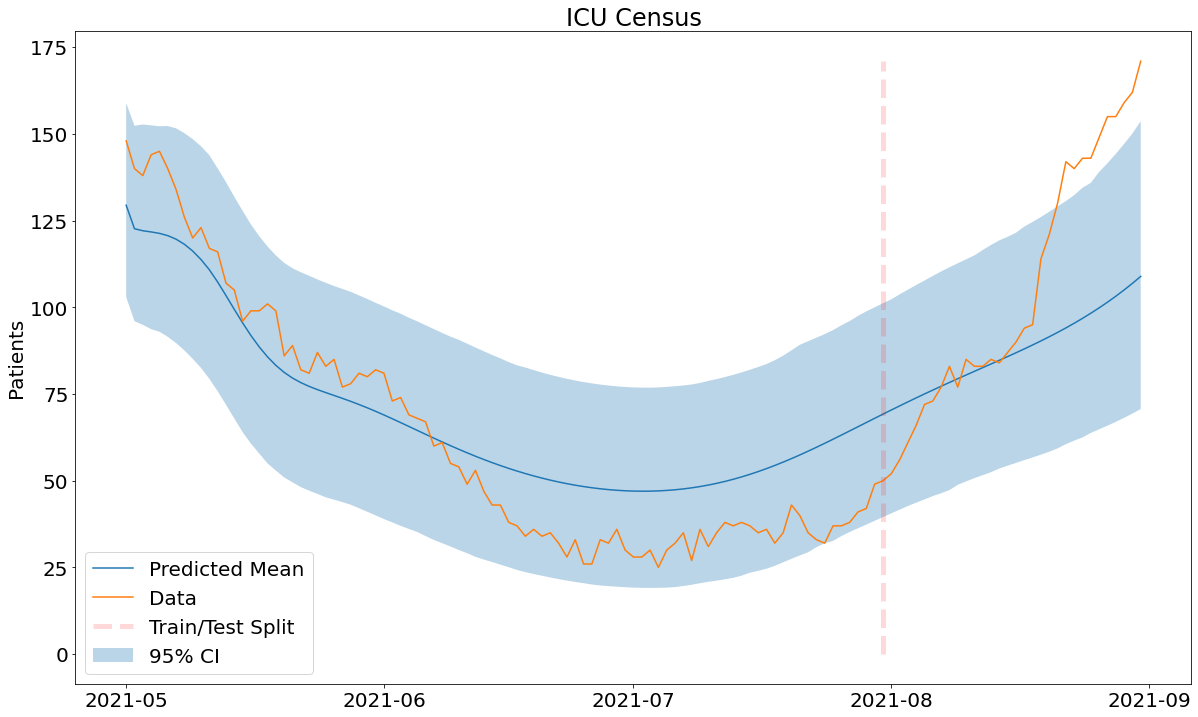

In [15]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_I_count_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['I_count'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_I_count_lower, pred_I_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_I_count_upper), max(y_test['I_count']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('ICU Census')
#plt.savefig('I_count.png')

Text(0.5, 1.0, 'Daily Deaths')

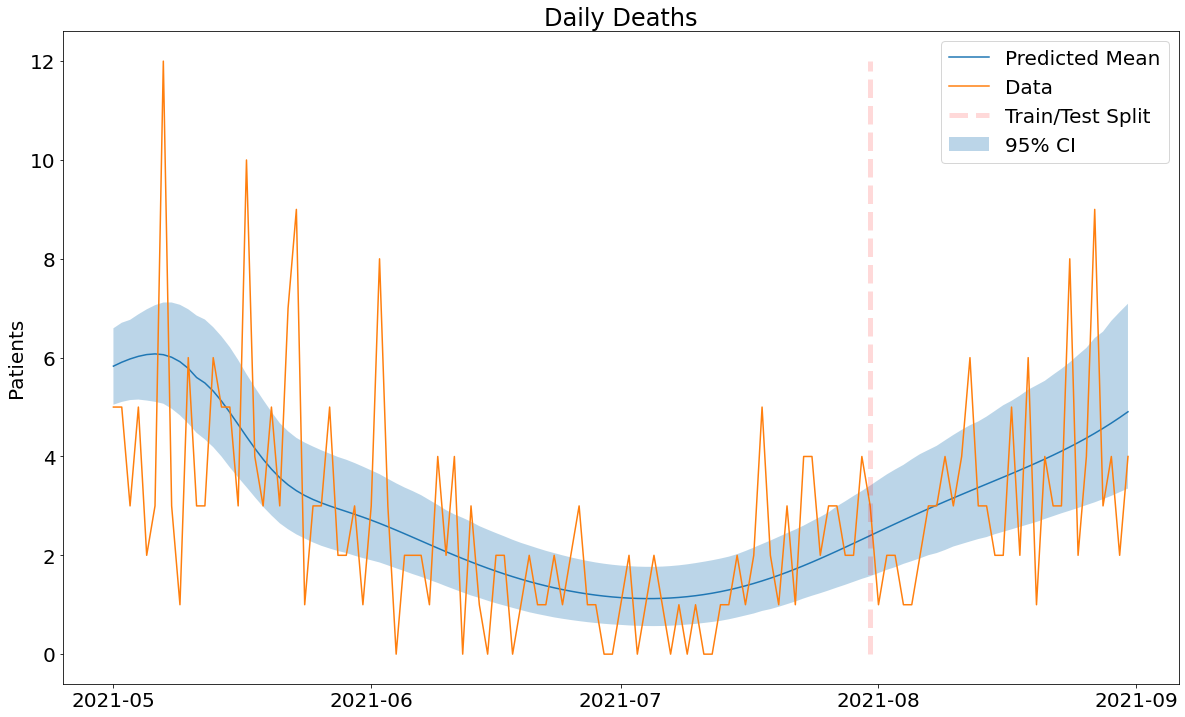

In [16]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_D_in_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['D_in'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_D_in_lower, pred_D_in_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_D_in_upper), max(y_test['D_in']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('Daily Deaths')
#plt.savefig('D_in.png')

In [40]:
new_config.to_json("/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/after_training_eff.json")

In [ ]:
y_train

In [ ]:
model.init_count_G_params

In [ ]:
model.config.init_count_I.value

In [ ]:
new_config = model.config.update_from_model(model)

In [ ]:
new_config.to_json("/mnt/c/Users/kheut/Downloads/fix_after_600.json")

In [ ]:
model.variables

In [ ]:
model.init_count_G_params

In [ ]:
model.variables

In [ ]:
model.init_count_G_samples_constrained[0].numpy().min(), model.init_count_G_samples_constrained[0].numpy().max()

In [ ]:
tfp.bijectors.Softplus.inverse(17/100)

In [ ]:
new_config.init_count_I.value

In [ ]:
model.config.init_count_G.value[1]['scale']

In [ ]:
model.init_count_G_params

In [ ]:
tf.random.normal((1000, ))

In [72]:
[df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values]

[array(['2021-07-31T00:00:00.000000000'], dtype='datetime64[ns]'),
 array(['2021-07-31T00:00:00.000000000'], dtype='datetime64[ns]')]